# House Price Prediction

```Data/house_price.csv```には、住宅の価格(```SalePrice```)と住宅の関連情報が格納されています。

- このデータを用いて、住宅の価格(```SalePrice```)を予測するモデルを構築、評価しなさい。
- データ中身を確認しながら、適切な特徴量エンジニアリングやモデル選定ための考えもまとめてください。

In [2]:
import numpy as np
import pandas as pd

In [3]:
#データの読み込み
house_price = pd.read_csv("Data/house_price.csv")
house_price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#ロジスティック回帰クラスのインポート
from sklearn.linear_model import LogisticRegression

In [5]:
#モデルのハイパーパラメータの選択
model=LogisticRegression(solver='lbfgs',  multi_class='auto')

In [6]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
#欠損値の削除
#暖炉ガレージなどの有無→それらの質や大きさなど詳細の質問になっている項目では欠損値を、0，Noneで埋めた
#それ以外は場合によって中央値や最頻値で埋めた
house_price_na = (house_price.isnull().sum() / len(house_price)) * 100
house_price_na = house_price_na.drop(house_price_na[house_price_na == 0].index).sort_values(ascending=False)[:30]#欠損値が含まれる変数のみ抽出
missing_data = pd.DataFrame({'Missing Ratio' :house_price_na})#データフレームに入れる
missing_data.head(30)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
MasVnrType,59.726027
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945


In [8]:
house_price["PoolQC"] = house_price["PoolQC"].fillna("None") #プールがない

In [9]:
house_price["MiscFeature"] = house_price["MiscFeature"].fillna("None") #その他機能がない

In [10]:
house_price["Alley"] = house_price["Alley"].fillna("None") #路地へのアクセスがない

In [11]:
house_price["Fence"] = house_price["Fence"].fillna("None") #フェンスがない

In [12]:
house_price["FireplaceQu"] = house_price["FireplaceQu"].fillna("None") #暖炉がない

In [13]:
#敷地につながる道路の直線フィートの中央値を欠損値に代入
house_price["LotFrontage"] = house_price["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [14]:
#ガレージ関連、noneを入れる
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    house_price[col] = house_price[col].fillna('None')

In [15]:
#ガレージ関連、0を欠損値に代入
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    house_price[col] = house_price[col].fillna(0)

In [16]:
#地下室関連、欠損値に0を入れる
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    house_price[col] = house_price[col].fillna(0)

In [17]:
#地下室関連、欠損値にNoneを入れる
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    house_price[col] = house_price[col].fillna('None')

In [18]:
#MasVnrType石積ベニアタイプではない、MasVnrArea石積みベニヤ面積0
house_price["MasVnrType"] = house_price["MasVnrType"].fillna("None")
house_price["MasVnrArea"] = house_price["MasVnrArea"].fillna(0)

In [19]:
#RLが平均値から最も遠い値であるため、欠損値にRLを入れる
house_price['MSZoning'] = house_price['MSZoning'].fillna("RL")

In [20]:
#公共インフラは大抵あり予測に使えなさそうなので削除
house_price = house_price.drop(['Utilities'], axis=1)

In [21]:
#NAはTypicalなのでTypを入れる
house_price["Functional"] = house_price["Functional"].fillna("Typ")

In [22]:
#一つある欠損値には最頻のSBrkrを入れる
house_price['Electrical'] = house_price['Electrical'].fillna("SBrkr")

In [23]:
#一つある欠損値には最頻のTAを入れる
house_price['KitchenQual'] = house_price['KitchenQual'].fillna("TA")

In [24]:
#家の外装について、欠損値には最頻値を入れる
house_price['Exterior1st'] = house_price['Exterior1st'].fillna(house_price['Exterior1st'].mode()[0])
house_price['Exterior2nd'] = house_price['Exterior2nd'].fillna(house_price['Exterior2nd'].mode()[0])

In [25]:
#販売形態、最頻値のWDを入れる
house_price['SaleType'] = house_price['SaleType'].fillna("WD")

In [26]:
#欠損値が削除できているか確認
house_price_na = (house_price.isnull().sum() / len(house_price)) * 100
house_price_na = house_price_na.drop(house_price_na[house_price_na == 0].index).sort_values(ascending=False)[:30]#欠損値が含まれる変数のみ抽出
missing_data = pd.DataFrame({'Missing Ratio' :house_price_na})#データフレームに入れる
missing_data.head()

,Missing Ratio


In [27]:
#カテゴリーデータの処理
#順序データを文字データに変換
house_price['MSSubClass'] = house_price['MSSubClass'].apply(str)

house_price['OverallCond'] = house_price['OverallCond'].astype(str)

house_price['YrSold'] = house_price['YrSold'].astype(str)
house_price['MoSold'] = house_price['MoSold'].astype(str)

#カテゴリデータを数値データに変換
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual',
        'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 
        'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 
        'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(house_price[c].values)) 
    house_price[c] = lbl.transform(list(house_price[c].values))
        
print(house_price.shape)


(1460, 80)


In [28]:
#家全体の床面積の広さも価格に影響すると考えたので新たに追加する
house_price['TotalSF'] = house_price['TotalBsmtSF'] + house_price['1stFlrSF'] + house_price['2ndFlrSF']

In [29]:
pd.DataFrame(house_price).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
0,1,9,RL,65.0,8450,1,1,3,Lvl,Inside,...,3,4,None,0,4,2,WD,Normal,208500,2566
1,2,4,RL,80.0,9600,1,1,3,Lvl,FR2,...,3,4,None,0,7,1,WD,Normal,181500,2524
2,3,9,RL,68.0,11250,1,1,0,Lvl,Inside,...,3,4,None,0,11,2,WD,Normal,223500,2706
3,4,10,RL,60.0,9550,1,1,0,Lvl,Corner,...,3,4,None,0,4,0,WD,Abnorml,140000,2473
4,5,9,RL,84.0,14260,1,1,0,Lvl,FR2,...,3,4,None,0,3,2,WD,Normal,250000,3343


In [30]:
#カテゴリーデータをダミー変数にする
house_price_a = pd.get_dummies(house_price)
print(house_price_a.shape)

(1460, 223)


In [31]:
pd.DataFrame(house_price_a).head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,9,65.0,8450,1,1,3,0,7,4,...,False,False,False,True,False,False,False,False,True,False
1,2,4,80.0,9600,1,1,3,0,6,7,...,False,False,False,True,False,False,False,False,True,False
2,3,9,68.0,11250,1,1,0,0,7,4,...,False,False,False,True,False,False,False,False,True,False
3,4,10,60.0,9550,1,1,0,0,7,4,...,False,False,False,True,True,False,False,False,False,False
4,5,9,84.0,14260,1,1,0,0,8,4,...,False,False,False,True,False,False,False,False,True,False


In [32]:
#データの確認
house_price.describe()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,TotalSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,6.214384,69.863699,10516.828082,0.995890,0.993836,1.942466,0.062329,6.099315,4.575342,...,3.409589,15.060959,2.758904,2.991096,3.504795,43.489041,6.492466,1.815753,180921.195890,2567.048630
std,421.610009,3.543318,22.027677,9981.264932,0.063996,0.249667,1.409156,0.276232,1.382997,1.112799,...,29.317331,55.757415,40.177307,0.140703,1.082912,496.123024,2.975444,1.328095,79442.502883,821.714421
min,1.000000,0.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,334.000000
25%,365.750000,4.000000,60.000000,7553.500000,1.000000,1.000000,0.000000,0.000000,5.000000,4.000000,...,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,5.000000,1.000000,129975.000000,2009.500000
50%,730.500000,5.000000,69.000000,9478.500000,1.000000,1.000000,3.000000,0.000000,6.000000,4.000000,...,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,7.000000,2.000000,163000.000000,2474.000000
75%,1095.250000,9.000000,79.000000,11601.500000,1.000000,1.000000,3.000000,0.000000,7.000000,5.000000,...,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,9.000000,3.000000,214000.000000,3004.000000
max,1460.000000,14.000000,313.000000,215245.000000,1.000000,2.000000,3.000000,2.000000,10.000000,8.000000,...,508.000000,480.000000,738.000000,3.000000,4.000000,15500.000000,11.000000,4.000000,755000.000000,11752.000000


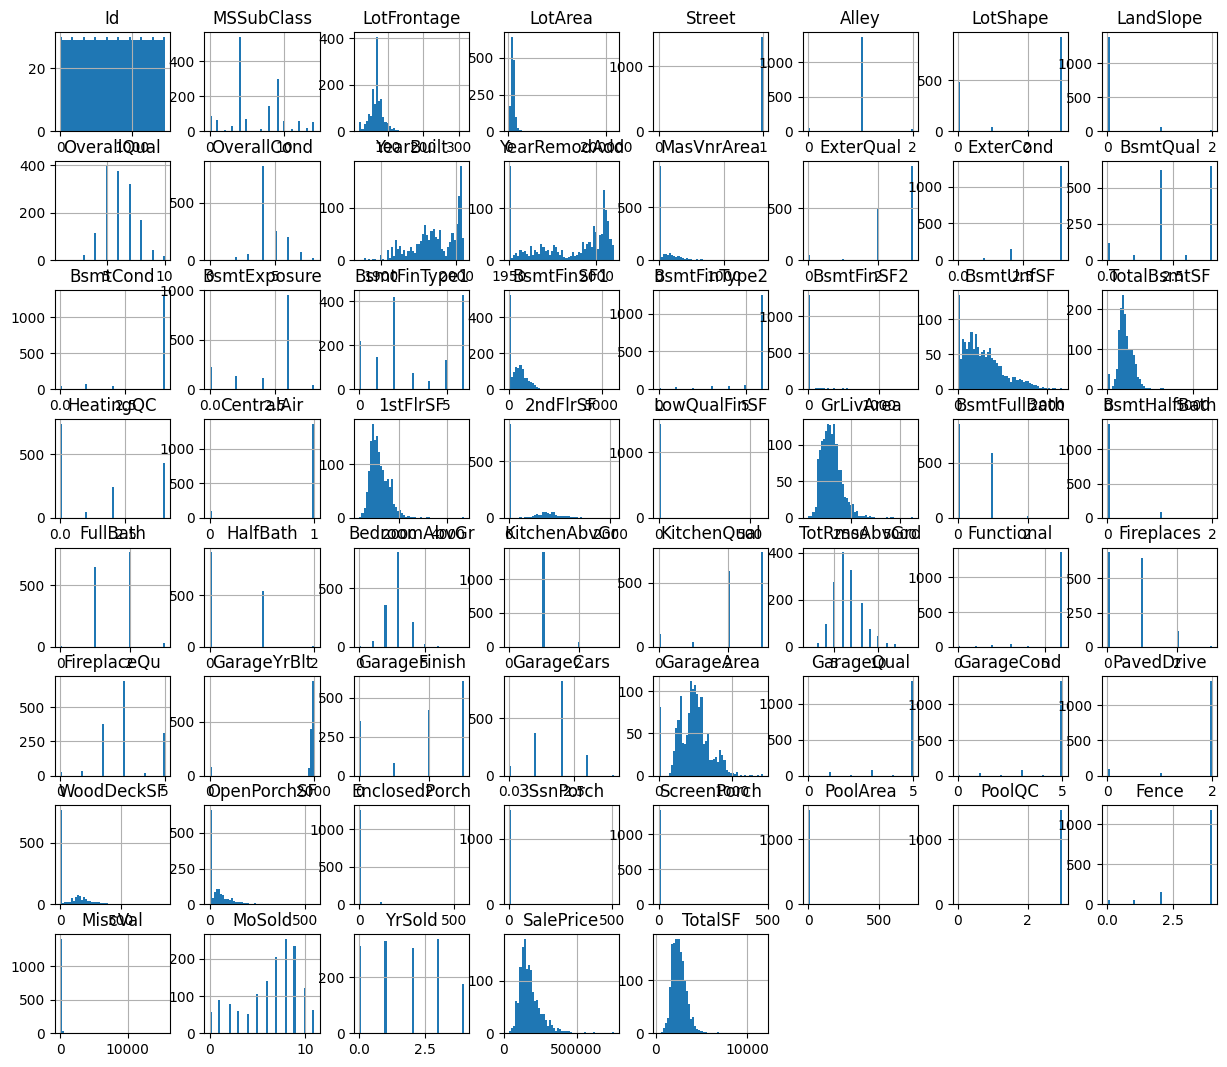

In [33]:
#グラフ化する
import matplotlib.pyplot as plt
house_price_a.hist(bins=50, figsize=(15, 13))
plt.savefig('house_hist.png')
plt.show()

In [42]:
#相関係数を求める
house_price_a.corr()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,1.000000,0.019912,-0.009921,-0.033226,0.008916,-0.002855,0.032122,0.005847,-0.028365,0.012609,...,-0.020738,-0.018998,0.038920,0.026133,0.007009,-0.034852,-0.009018,0.004865,0.015881,-0.020738
MSSubClass,0.019912,1.000000,0.228341,0.092594,-0.020293,-0.124793,-0.066026,-0.004558,-0.011481,0.083249,...,0.006382,-0.086755,0.014334,0.092132,-0.008880,0.070815,0.125135,0.027802,0.024273,-0.090395
LotFrontage,-0.009921,0.228341,1.000000,0.304522,-0.037349,-0.065084,-0.138877,0.065603,0.234812,-0.053281,...,-0.051283,0.128995,-0.023074,-0.091864,-0.021725,-0.036570,-0.018040,0.016250,-0.074146,0.127293
LotArea,-0.033226,0.092594,0.304522,1.000000,-0.197131,-0.029676,-0.165315,0.436868,0.105806,-0.005636,...,-0.015040,0.020039,-0.005722,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711,0.022635
Street,0.008916,-0.020293,-0.037349,-0.197131,1.000000,-0.001587,-0.010224,-0.179360,0.058823,0.042848,...,0.003766,0.019397,0.002915,0.006539,0.017512,0.003367,-0.112734,0.007571,-0.002140,0.019657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,-0.034852,0.070815,-0.036570,-0.013208,0.003367,0.001295,0.011443,-0.011831,-0.041677,-0.038888,...,-0.003073,-0.015827,-0.002378,0.020457,-0.014289,1.000000,-0.004772,-0.006177,-0.112080,-0.016038
SaleCondition_Alloca,-0.009018,0.125135,-0.018040,0.008966,-0.112734,0.002248,0.036030,0.034397,-0.044950,-0.033444,...,-0.005337,-0.027489,-0.004131,0.035530,-0.024817,-0.004772,1.000000,-0.010729,-0.194663,-0.027856
SaleCondition_Family,0.004865,0.027802,0.016250,-0.010781,0.007571,-0.067919,0.034095,0.037417,-0.025515,-0.023873,...,-0.006909,-0.035587,-0.005348,0.028599,-0.032128,-0.006177,-0.010729,1.000000,-0.252006,-0.036062
SaleCondition_Normal,0.015881,0.024273,-0.074146,0.005711,-0.002140,-0.054461,-0.005162,-0.004330,-0.143282,0.161642,...,0.027414,-0.645698,-0.097031,0.634322,-0.582947,-0.112080,-0.194663,-0.252006,1.000000,-0.654323


In [59]:
#SalePriceの相関係数のみ確認する
y_column='SalePrice'

corr_matrix = house_price_a.corr()
y_corr =corr_matrix[y_column]

#表示
y_corr

Id                      -0.021917
MSSubClass               0.054795
LotFrontage              0.334771
LotArea                  0.263843
Street                   0.041036
Alley                    0.083121
LotShape                -0.255580
LandSlope                0.051152
OverallQual              0.790982
OverallCond             -0.077856
YearBuilt                0.522897
YearRemodAdd             0.507101
MasVnrArea               0.472614
ExterQual               -0.636884
ExterCond                0.117303
BsmtQual                -0.593734
BsmtCond                 0.091503
BsmtExposure            -0.309043
BsmtFinType1            -0.098734
BsmtFinSF1               0.386420
BsmtFinType2             0.072717
BsmtFinSF2              -0.011378
BsmtUnfSF                0.214479
TotalBsmtSF              0.613581
HeatingQC               -0.400178
CentralAir               0.251328
1stFlrSF                 0.605852
2ndFlrSF                 0.319334
LowQualFinSF            -0.025606
GrLivArea     

In [35]:
#多くの機械学習アルゴリズムは、入力特徴量のスケールが大きく異なると性能をうまく発揮ないそうなので、
# すべでの変数のスケールを統一するために正規化スケーリングを行う
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_features =  scaler.fit_transform(house_price_a)
housing_tr = pd.DataFrame(scaled_features, columns=house_price_a.columns)
housing_tr.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.000000,0.642857,0.150685,0.033420,1.0,0.5,1.0,0.0,0.666667,0.500,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000685,0.285714,0.202055,0.038795,1.0,0.5,1.0,0.0,0.555556,0.875,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.001371,0.642857,0.160959,0.046507,1.0,0.5,0.0,0.0,0.666667,0.500,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.002056,0.714286,0.133562,0.038561,1.0,0.5,0.0,0.0,0.666667,0.500,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.002742,0.642857,0.215753,0.060576,1.0,0.5,0.0,0.0,0.777778,0.500,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [63]:
#訓練データとテストデータに分割する
#線形回帰分析を用いる
#相関係数が高く、実感としても関連が強そうな項目を説明変数として選んだ。
#相関については散布図で確認したかったが、うまく出力できなかったので、単に相関係数が高いものを選んだ。
#説明変数
exp_vars = (['TotalSF','YrSold','OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','ExterQual','BsmtQual'])
X = housing_tr[exp_vars]
X.head()

,TotalSF,YrSold,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual
0,0.195481,0.50,0.666667,0.949275,0.883333,0.12250,0.666667,0.5
1,0.191802,0.25,0.555556,0.753623,0.433333,0.00000,1.000000,0.5
2,0.207742,0.50,0.666667,0.934783,0.866667,0.10125,0.666667,0.5
3,0.187336,0.00,0.666667,0.311594,0.333333,0.00000,1.000000,1.0
4,0.263531,0.50,0.777778,0.927536,0.833333,0.21875,0.666667,0.5


In [64]:
#目的変数
y = housing_tr['SalePrice'] 
y.head()

0    0.241078
1    0.203583
2    0.261908
3    0.145952
4    0.298709
Name: SalePrice, dtype: float64

In [65]:
print(X.shape, y.shape)

(1460, 8) (1460,)


In [66]:
#データの分割を行う
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(1022, 8) (438, 8)


以上で特徴量エンジニアリングが終了した。
スケーリングや、データの分割の細かい設定をどのように判断して設定すれば良いのか、やっている操作が正しいのかよく分らなかった。
以降、線形回帰モデルを用い学習して予測する。

In [72]:
model=LinearRegression() # 線形回帰モデル

In [73]:
model.fit(X_train,y_train) # モデルを訓練データに適合

LinearRegression()

In [74]:
y_predicted=model.predict(X_test) # テストデータで予測

In [75]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_predicted) # 予測精度（平均二乗誤差）の評価

0.0022864559394719466

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

# モデルの評価
print('testing score:', r2_score(y_test, y_pred))

testing score: 0.8339526962670305


In [68]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(max_depth = 10).fit(X_train, y_train)
y_pred = tree_regressor.predict(X_test)
print('testing score:', r2_score(y_test, y_pred))

testing score: 0.7225291765854907


In [ ]:
#データの処理の仕方が正しければ、それなりに予測できたといえるが、quality関係の変数の処理の仕方が間違っている可能性があることと、
#多重共線性についてどのように判断すれば良いのかいくつかサイトを読んだがよく理解できず、モデルが適切ではない可能性があると思った。